## Middleware
Middleware provides a way to more tightly control what happens inside the agent. Middleware is useful for the following:

* Tracking agent behavior with logging, analytics, and debugging.
* Transforming prompts, tool selection, and output formatting.
* Adding retries, fallbacks, and early termination logic.
* Applying rate limits, guardrails, and PII detection.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

### Summarization MiddleWare
Automatically summarize conversation history when approaching token limits, preserving recent messages while compressing older context. Summarization is useful for the following:

* Long-running conversations that exceed context windows.
* Multi-turn dialogues with extensive history.
* Applications where preserving full conversation context matters.

In [2]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage

### Messagebased summarization
agent=create_agent(
    model="groq:qwen/qwen3-32b",
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="groq:qwen/qwen3-32b",
            trigger=("messages",10),
            keep=("messages",4)
        )
    ]
)

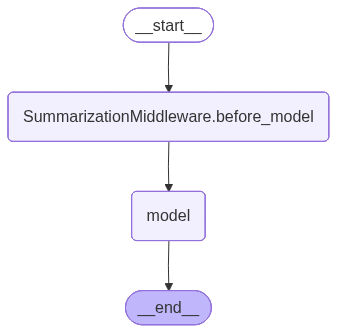

In [3]:
agent

In [4]:
### Run with thread id
config={"configurable":{"thread_id":"test-1"}}

In [5]:
# Alternative test data
questions = [
    "What is 2+2?",
    "What is 10*5?",
    "What is 100/4?",
    "What is 15-7?",
    "What is 3*3?",
    "What is 4*4?",
]

In [6]:
for q in questions:
    response=agent.invoke({"messages":[HumanMessage(content=q)]},config)
    print(f"Messages: {response}")
    print(f"Messages: {len(response['messages'])}")

Messages: {'messages': [HumanMessage(content='What is 2+2?', additional_kwargs={}, response_metadata={}, id='f0a4e4b4-3b5e-489a-9774-3e438ea97191'), AIMessage(content='<think>\nOkay, so the user is asking "What is 2+2?" Hmm, that seems straightforward, but maybe I should think through it carefully. Let me start by recalling basic addition. In standard arithmetic, 2 plus 2 is 4. But wait, sometimes in different contexts or number systems, the result might be different. For example, in modular arithmetic, like modulo 3, 2+2 would be 1. But the question doesn\'t specify any context, so I should assume it\'s in the usual decimal system.\n\nLet me also consider if there\'s any trick or wordplay here. Sometimes people ask this question humorously, expecting a non-mathematical answer. But the user is probably just looking for the straightforward sum. Another angle: in some programming languages or specific contexts, the \'+\' operator might do something else, like string concatenation. But ag

### Token size

In [7]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver

@tool
def search_hotels(city: str) -> str:
    """Search hotels - returns long response to use more tokens."""
    return f"""Hotels in {city}:
    1. Grand Hotel - 5 star, $350/night, spa, pool, gym
    2. City Inn - 4 star, $180/night, business center
    3. Budget Stay - 3 star, $75/night, free wifi"""


agent=create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="groq:qwen/qwen3-32b",
            trigger=("tokens",550),
            keep=("tokens",200),
        ),
    ]
)

config = {"configurable": {"thread_id": "test-1"}}

# Token counter (approximate)
def count_tokens(messages):
    total_chars = sum(len(str(m.content)) for m in messages)
    return total_chars // 4  # 4 chars ≈ 1 token

In [8]:
# Run test
cities = ["Paris", "London", "Tokyo", "New York", "Dubai", "Singapore"]

for city in cities:
    response = agent.invoke(
        {"messages": [HumanMessage(content=f"Find hotels in {city}")]},
        config=config
    )
    
    tokens = count_tokens(response["messages"])
    print(f"{city}: ~{tokens} tokens, {len(response['messages'])} messages")
    print(f"{(response['messages'])}")

Paris: ~172 tokens, 4 messages
[HumanMessage(content='Find hotels in Paris', additional_kwargs={}, response_metadata={}, id='5009806f-7c25-4f83-95aa-2a1cd138ac16'), AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user wants to find hotels in Paris. Let me check the available tools. There's a function called search_hotels that takes a city parameter. The city here is Paris. I need to make sure the function is called correctly. Since the user specified Paris, I should use that as the argument. The function is designed to return a long response, so I don't need to worry about token limits. Just call search_hotels with city set to Paris.\n", 'tool_calls': [{'id': 'skv5v5t6s', 'function': {'arguments': '{"city":"Paris"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 155, 'total_tokens': 275, 'completion_time': 0.192506378, 'completion_tokens_details': {'reasoning_tokens': 95}, 'prompt_

### Fraction

In [9]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver

@tool
def search_hotels(city: str) -> str:
    """Search hotels."""
    return f"Hotels in {city}: Grand Hotel $350, City Inn $180, Budget Stay $75"

# LOW fraction for testing!
agent = create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="groq:qwen/qwen3-32b",
            trigger=("fraction", 0.005),  # 0.5% = ~640 tokens
            keep=("fraction", 0.002),     # 0.2% = ~256 tokens
        ),
    ],
)

config = {"configurable": {"thread_id": "test-1"}}

# Token counter
def count_tokens(messages):
    return sum(len(str(m.content)) for m in messages) // 4

# Test
cities = ["Paris", "London", "Tokyo", "New York", "Dubai", "Singapore"]

for city in cities:
    response = agent.invoke(
        {"messages": [HumanMessage(content=f"Hotels in {city}")]},
        config=config
    )
    tokens = count_tokens(response["messages"])
    fraction = tokens / 128000  # gpt-4o-mini context
    print(f"{city}: ~{tokens} tokens ({fraction:.4%}), {len(response['messages'])} msgs")
    print(response['messages'])

Paris: ~74 tokens (0.0578%), 4 msgs
[HumanMessage(content='Hotels in Paris', additional_kwargs={}, response_metadata={}, id='e4d48f5a-193a-4bc7-9e20-805b7a5ba2de'), AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking for hotels in Paris. Let me check the tools available. There's a function called search_hotels that takes a city parameter. Since the user specified Paris, I need to call that function with the city set to Paris. I'll make sure the parameters are correctly formatted as JSON and return the tool call as specified.\n", 'tool_calls': [{'id': '8cv08msn3', 'function': {'arguments': '{"city":"Paris"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 147, 'total_tokens': 242, 'completion_time': 0.141112127, 'completion_tokens_details': {'reasoning_tokens': 70}, 'prompt_time': 0.005984693, 'prompt_tokens_details': None, 'queue_time': 0.158967212, 'total_time': 0.1470968

### Human In the Loop MiddleWare
Pause agent execution for human approval, editing, or rejection of tool calls before they execute. Human-in-the-loop is useful for the following:

* High-stakes operations requiring human approval (e.g. database writes, financial transactions).
* Compliance workflows where human oversight is mandatory.
Long-running conversations where human feedback guides the agent.

In [10]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver

def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

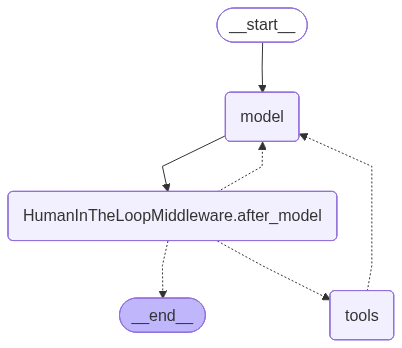

In [19]:
agent=create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool":{
                    "allowed_decisions":["approve","edit","reject"]
                },
                "read_email_tool":False,

            }
        )
    ]
)
agent

In [20]:
config = {"configurable": {"thread_id": "test-approve"}}
# Step 1: Request
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'")]},
    config=config
)

In [21]:
print(f"✅ Result: {result['messages'][-1].content}")

✅ Result: 


In [22]:

result


{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='834b52dc-72b7-4fe6-a4ed-2e98255f493b'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, let me see. The user wants to send an email to john@test.com with the subject 'Hello' and body 'How are you?'. I need to check which tool to use here. The available tools are read_email_tool and send_email_tool. Since the action is sending an email, the send_email_tool is the right choice. The parameters required for send_email_tool are recipient, subject, and body. The user provided all three: recipient is john@test.com, subject is 'Hello', and body is 'How are you?'. I just need to structure these into the function call correctly. No need to use the read_email_tool here because the user isn't asking to read an email. Everything seems in order, so I'll prepare the tool_call with the send_email_tool and the provided argu

In [23]:
from langgraph.types import Command

if "__interrupt__" in result:
    print("Approving command...") 
    result=agent.invoke(
        Command(
            resume={
                "decisions":[
                    {"type":"approve"}
                ]
            }
        ),
        config=config
    )
    print(f"✅ Result: {result['messages'][-1].content}")
    

Approving command...
✅ Result: The email has been successfully sent to john@test.com with the subject "Hello". Let me know if you need anything else!


### Result

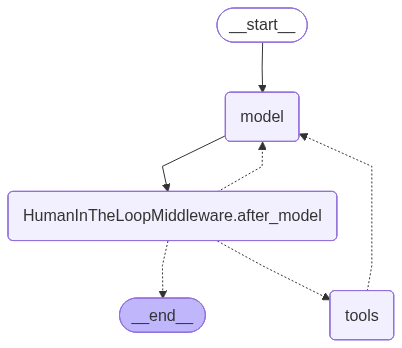

In [31]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

agent = create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email_tool": False,
            }
        ),
    ],
)
agent

In [32]:
config = {"configurable": {"thread_id": "test-reject"}}
# Step 1: Request
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'")]},
    config=config)

In [33]:
# Step 2: Reject
if "__interrupt__" in result:
    print("⏸️ Paused! Approving...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {"type": "reject"}
                ]
            }
        ),
        config=config
    )
    
    print(f"✅ Result: {result['messages'][-1].content}")

⏸️ Paused! Approving...
✅ Result: The email to john@test.com with subject "Hello" could not be sent. The tool call was rejected. Would you like me to review the email content or attempt to send it again?


### Edit

In [34]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

agent = create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email_tool": False,
            }
        ),
    ],
)

In [36]:
config = {"configurable": {"thread_id": "test-edit"}}

# Step 1: Request (with wrong info)
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to wrong@email.com with subject 'Test' and body 'Hello'")]},
    config=config
)

In [37]:

result

{'messages': [HumanMessage(content="Send email to wrong@email.com with subject 'Test' and body 'Hello'", additional_kwargs={}, response_metadata={}, id='1f47a02b-4363-428a-ac86-5d38e2459618'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, let's see. The user wants to send an email to wrong@email.com with the subject 'Test' and body 'Hello'. I need to check which tool to use here. The available tools are read_email_tool and send_email_tool. Since the user is asking to send an email, the send_email_tool is the right choice.\n\nLooking at the parameters for send_email_tool, it requires recipient, subject, and body. The user provided all three: recipient is wrong@email.com, subject is 'Test', and body is 'Hello'. So I should call the send_email_tool with these arguments. I don't need to use the read_email_tool here because the request is about sending, not reading. Just need to make sure all required parameters are included in the tool call.\n", 'tool_calls': [{'id

In [38]:
# Step 2: Edit and approve
if "__interrupt__" in result:
    print("⏸️ Paused! Editing...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {
                        "type": "edit",
                        "edited_action": {
                            "name": "send_email_tool",      # Tool name
                            "args": {                   # New arguments
                                "recipient": "correct@email.com",
                                "subject": "Corrected Subject",
                                "body": "This was edited by human before sending"
                            }
                        }
                    }
                ]
            }
        ),
        config=config
    )
    
    print(f"✏️ Result: {result['messages'][-1].content}")

⏸️ Paused! Editing...
✏️ Result: The email has been successfully sent to **correct@email.com** with the subject **"Corrected Subject"** and the body **"This was edited by human before sending"**. The original recipient and content were adjusted before delivery. Let me know if you need further assistance!
